# Market Basket Analysis for E-commerce Project
<img src="Market basket.jpeg"  width="250"/>

#### Metadata
The dataset has 3 columns and 38765 rows 
+ `Member_number`(int) - Unique number of a customer
+ `Date`(str) - The date a transaction was done
+ `itemDescription`(str) - The specific item bought
Every row represents a single item purchase.

## Analysis Requirements
+ Data Preparation
+ Exploratory Data Analysis
+ Market Basket Analysis
+ Visualization
+ Interpretation and insights
+ Recommendations
+ Presentation


# Step 1: Data preparation


In [1]:
# Import necessary packages 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules 

In [2]:
#Read CSV file
file_path = r'Market Basket Analysis - Groceries_dataset.csv'
groceries_df = pd.read_csv(file_path)
groceries_df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
#Check the dataframe information
groceries_df.info()
print("Dataframe Shape: {}".format(groceries_df.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB
Dataframe Shape: (38765, 3)


In [4]:
# Check for null values
groceries_df.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [5]:
#convert Member number from integer to string
groceries_df['Member_number'] = groceries_df['Member_number'].astype(str)

# Convert the date column into datetime format
groceries_df['Date'] = pd.to_datetime(groceries_df['Date'], dayfirst=True)

# Extract day, month and year information and create new columns
groceries_df['Day'] = groceries_df['Date'].dt.day
groceries_df['Month'] = groceries_df['Date'].dt.strftime('%B')
groceries_df['Year'] = groceries_df['Date'].dt.year
groceries_df.head(4)

,Member_number,Date,itemDescription,Day,Month,Year
0,1808,2015-07-21,tropical fruit,21,July,2015
1,2552,2015-01-05,whole milk,5,January,2015
2,2300,2015-09-19,pip fruit,19,September,2015
3,1187,2015-12-12,other vegetables,12,December,2015


In [7]:
#Check for duplicates found 759 duplicates
groceries_df.duplicated().sum()

#Remove duplicates
groceries_df = groceries_df.drop_duplicates()

print(groceries_df.shape)
print("Rows before removing duplicates: 38765")
print("Rows after removing duplicates: 38006")

(38006, 6)
Rows before removing duplicates: 38765
Rows after removing duplicates: 38006


# Step 2: Exploratory Data Analysis

## Count of unique customers

In [8]:
# get the number of unique customers
no_of_customers = groceries_df['Member_number'].nunique()
print("The total number of unique customers is: {}".format(no_of_customers))


The total number of unique customers is: 3898


## Count of unique items

In [29]:
# get the number of unique items 
no_of_items = groceries_df['itemDescription'].nunique()
print("The number of unique items purchased is: {}".format(no_of_items))

The number of unique items purchased is: 167


## Most frequent buyers and average visits per customer
 The number of visits also translates to the number of transactions for that buyer

In [9]:
# Get the member number and the number of dates they have visited the store to calculate the number of visits
most_frequent_buyers = groceries_df.groupby('Member_number')['Date'].nunique().sort_values(ascending=False)
avg_visits = most_frequent_buyers.mean()
print("The average number of visits per customer is: {}".format(round(avg_visits)))
most_frequent_buyers.head(10)

The average number of visits per customer is: 4


Member_number
2271    11
1379    11
4338    11
3737    11
2193    11
3593    10
1052    10
2625    10
3484    10
4217    10
Name: Date, dtype: int64

## Percentage of least frequent buyers 

In [10]:
#Get the least frequent buyers
least_frequent_buyers = groceries_df.groupby('Member_number')['Date'].nunique().sort_values(ascending=True)

# Get the number of buyers who have visited the store less than the average number of visits per customer
least = least_frequent_buyers[least_frequent_buyers < 4]
print("Number of buyers who have visited the store less than 4 times: {}".format(len(least)))

#Get the percentage of customers who have visited less than avg number of visits per customer
perc = float(len(least)/groceries_df['Member_number'].nunique()*100)
print(f"That is {round(perc, 2)} percent of the total customers")


Number of buyers who have visited the store less than 4 times: 1849
That is 47.43 percent of the total customers


## Buyers who have purchased the most items & the Average items bought per buyer

In [11]:
# Get the buyers who have purchased the most items
items_per_customer = groceries_df['Member_number'].value_counts().sort_values(ascending=False)

#what is the average items per buyer
avg_items_per_customer = items_per_customer.mean()
print("The average items bought per customer is: {}\n".format(round(avg_items_per_customer)))
print("Customers who have purchased the most items")
items_per_customer.head(10)


The average items bought per customer is: 10

Customers who have purchased the most items


Member_number
3180    35
3737    33
3050    32
2051    31
3915    30
2433    30
2625    30
2851    29
2394    29
3872    29
Name: count, dtype: int64

## Customers who have purchased the least items
These are the buyers who have bought items less than the average items per buyer (10)


In [12]:
# Get the least frequent buyers
customers = groceries_df['Member_number'].value_counts()

# Get the number of customers who have purchased less than 10 items
less_than_10 = len(customers[customers < 10])
perc = round(less_than_10 / groceries_df['Member_number'].nunique() * 100, 2)

print("Number of customers who have bought less than 10 items:{}".format(less_than_10))
print("That is {} percent of the total customers".format(perc))
customers.tail(10)

Number of customers who have bought less than 10 items:2061
That is 52.87 percent of the total customers


Member_number
4247    2
2783    2
2572    2
2417    2
2717    1
4816    1
4029    1
4151    1
4565    1
2640    1
Name: count, dtype: int64

## Top 10 Most purchased items

In [13]:
# Top 10 most purchased items
bought_items = groceries_df['itemDescription'].value_counts()
print("Top 10 most bought items")
bought_items.head(10)

Top 10 most bought items


itemDescription
whole milk          2363
other vegetables    1827
rolls/buns          1646
soda                1453
yogurt              1285
root vegetables     1041
tropical fruit      1014
bottled water        908
sausage              903
citrus fruit         795
Name: count, dtype: int64

## 10 Least bought items

In [14]:
# 10 least bought items
print("10 least bought items")
bought_items.tail(10)

10 least bought items


itemDescription
whisky                   8
salad dressing           6
make up remover          5
toilet cleaner           5
frozen chicken           5
rubbing alcohol          5
bags                     4
baby cosmetics           3
kitchen utensil          1
preservation products    1
Name: count, dtype: int64

## Count of items purchased every year & percentage increase in items purchased

In [30]:
# Get the items purchased for each year
yearly_sales = groceries_df['Year'].value_counts()
#percentage increase in items purchased
y2015 = len(groceries_df[groceries_df['Year'] == 2015])
y2014 = len(groceries_df[groceries_df['Year'] == 2014])
perc = (y2015 - y2014) / y2014 * 100
print("Percentage increase of the items purchased between 2014 and 2015: {}".format(round(perc, 2)))
yearly_sales

Percentage increase of the items purchased between 2014 and 2015: 10.85


Year
2015    19981
2014    18025
Name: count, dtype: int64

## Monthly purchases for every year

In [31]:
# monthly sales for each month through the years
monthly_sales = groceries_df.pivot_table(index='Month', columns='Year', values='Member_number', aggfunc='count')

month_highest_sales = groceries_df['Month'].mode()[0]
print("The month with the highest cumulative items purchased is {}".format(month_highest_sales))
monthly_sales

The month with the highest cumulative items purchased is August


Year,2014,2015
Month,,
April,1533,1661
August,1556,1875
December,1453,1504
February,1409,1517
January,1499,1751
July,1557,1683
June,1551,1656
March,1384,1671
May,1595,1753


# Step 3: Market Basket Analysis

## Get the support metrics for each item

In [17]:
# Support = number of transactions with item/total transactions
# get the number of transactions with each item
bought_items = groceries_df['itemDescription'].value_counts()

baskets = groceries_df.groupby(['Member_number', 'Date'])['itemDescription'].apply(list)
# create a list of lists of the transactions
baskets_list = list(baskets)
total_transactions = len(baskets_list)
# get the support metric for each item
support_metric = bought_items / total_transactions

# Display the support metric for each item
print("Support Metric for individual Items:\n")
support_metric.head()



Support Metric for individual Items:



itemDescription
whole milk          0.157923
other vegetables    0.122101
rolls/buns          0.110005
soda                0.097106
yogurt              0.085879
Name: count, dtype: float64

In [32]:
encoder = TransactionEncoder().fit(baskets_list)

# One-hot encode transactions
onehot = encoder.transform(baskets_list)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)

#apply apriori algorithm to compute frequent itemsets
frequent_itemsets = apriori(onehot, min_support = 0.005, use_colnames = True )
print("\nFrequent itemsets count: {}\n".format(len(frequent_itemsets)))

#getenerate rules using lift metric
rules = association_rules(frequent_itemsets, metric="lift")

#print all rules
print("\nAssociation rules for all items:")
rules.sort_values(by='zhangs_metric', ascending=False).head(10)


Frequent itemsets count: 126


Association rules for all items:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
9,(other vegetables),(frankfurter),0.122101,0.037760,0.005146,0.042146,1.116150,0.000536,1.004579,0.118536
8,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146
35,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,0.000565,1.007049,0.107508
34,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345,0.104587
30,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,0.000088,1.000963,0.016341
31,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613,0.015702
0,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,-0.000005,0.999874,-0.000702
1,(whole milk),(bottled beer),0.157923,0.045312,0.007151,0.045281,0.999330,-0.000005,0.999968,-0.000795
32,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811,-0.063965
33,(whole milk),(sausage),0.157923,0.060349,0.008955,0.056708,0.939663,-0.000575,0.996140,-0.070851


In [33]:
#print rules that show association, zhangs metric above 0
print("Rules that show a strong association:\nThese are items that are most likely to be bought together")
rules[rules['zhangs_metric'] > 0][['antecedents', 'consequents']]

Rules that show a strong association:
These are items that are most likely to be bought together


,antecedents,consequents
8,(frankfurter),(other vegetables)
9,(other vegetables),(frankfurter)
30,(soda),(sausage)
31,(sausage),(soda)
34,(sausage),(yogurt)
35,(yogurt),(sausage)


# Step 4: Visualization

### Average products per customer
Using a histogram to visualize the average items a customer buys. 

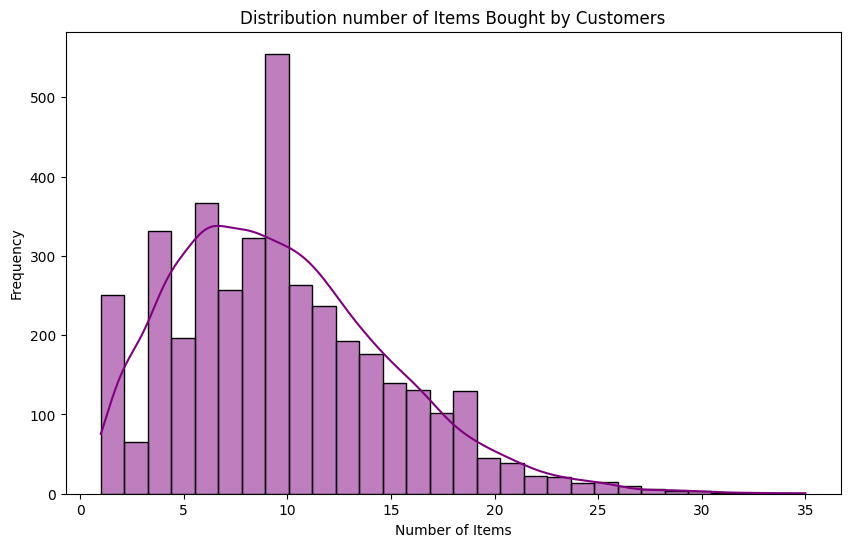

In [36]:
# Visualization: Distribution of items bought per customer
plt.figure(figsize=(10, 6))
sns.histplot(groceries_df['Member_number'].value_counts(), bins=30, kde=True, color='purple')
plt.title('Distribution number of Items Bought by Customers')
plt.xlabel('Number of Items')
plt.ylabel('Frequency')
plt.show()


### Distribution of visits per customer
This gets the counts of unique purchases done by each customer 

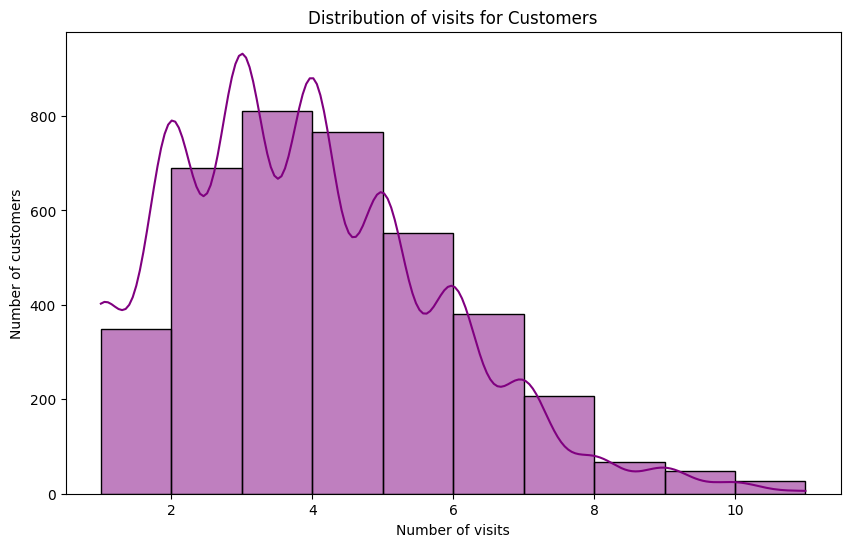

In [34]:
#Visualization: Histogram showing the distribution of visits per customer
plt.figure(figsize=(10, 6))
sns.histplot(groceries_df.groupby('Member_number')['Date'].nunique(), bins=10, kde=True, color='purple')
plt.title('Distribution of visits for Customers')
plt.xlabel('Number of visits')
plt.ylabel('Number of customers')
plt.show()

### Number of items per customer(Top 10)
This shows the top 10 customers with the highest number of items purchased

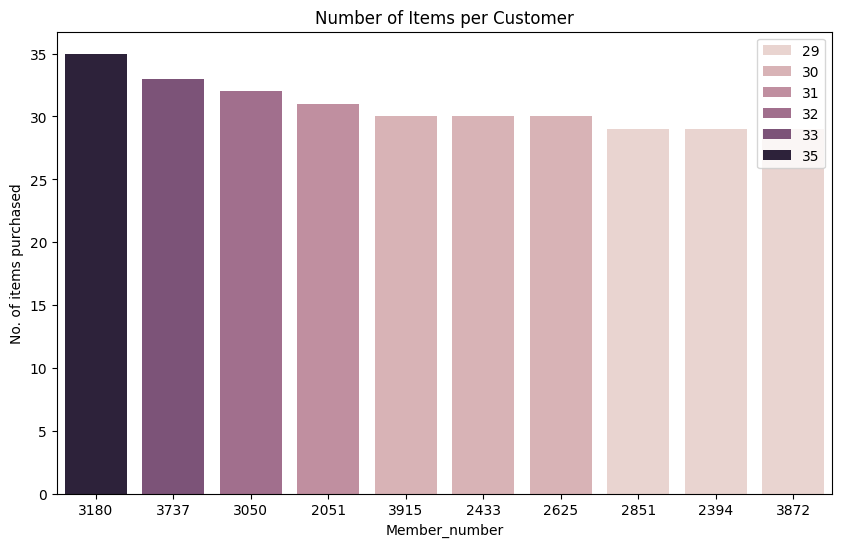

In [22]:
#Visualization: Top 10 customers in terms of items purchased
items_per_customer = groceries_df['Member_number'].value_counts().sort_values(ascending=False)
top_ten_cst = items_per_customer.head(10)
# Create a DataFrame from items_per_customer
top_ten = top_ten_cst.reset_index()
top_ten.columns = ['Member_number', 'Count']

# Create the barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_ten, x='Member_number', y='Count', hue='Count', order=top_ten.sort_values('Count',ascending = False)['Member_number'] )
plt.title('Number of Items per Customer')
plt.ylabel('No. of items purchased')
plt.legend(loc='best')
plt.show()

### Monthly sales count for every year
This visualization gets the total items sold for every month through the years

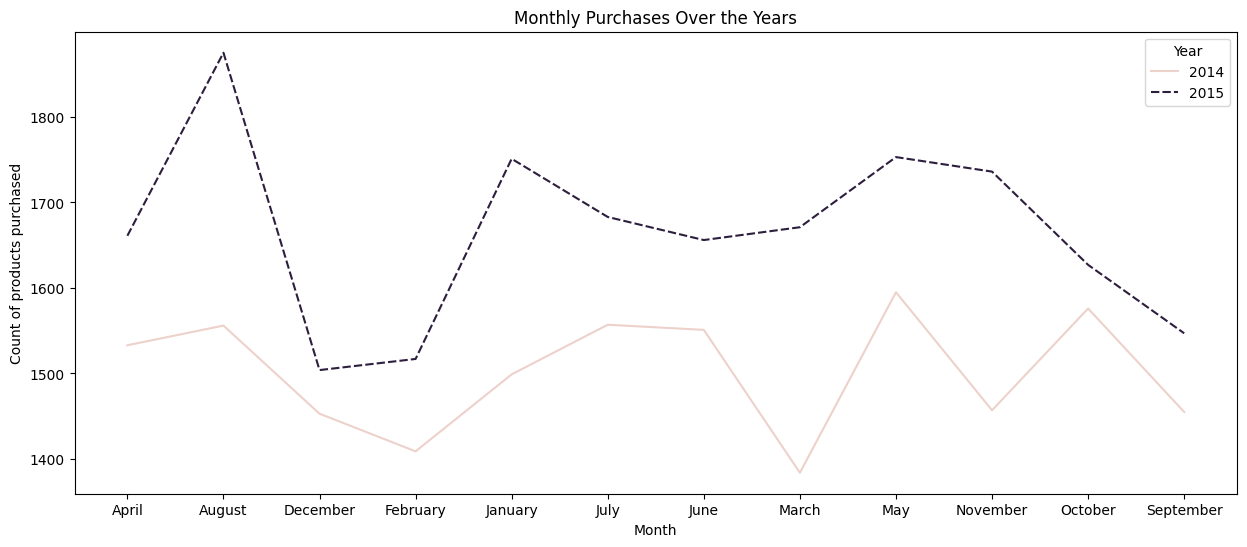

In [37]:
#create a dataframe out of monthly_Sales pivot table
monthly_sales = groceries_df.pivot_table(index='Month', columns='Year', values='Member_number', aggfunc='count')
monthly_sales_df = monthly_sales.reset_index()

# Melt the DataFrame to have Year as a column
monthly_sales_melted = monthly_sales_df.melt(id_vars='Month', var_name='Year', value_name='Sales count')
plt.figure(figsize=(15, 6))
# create a line plot showing trends per month for the different years
sns.lineplot(data=monthly_sales_melted,  x='Month', y='Sales count', hue='Year', style='Year')
plt.title('Monthly Purchases Over the Years')
plt.xlabel('Month')
plt.ylabel('Count of products purchased')

plt.show()

### Top 10 most purchased items 

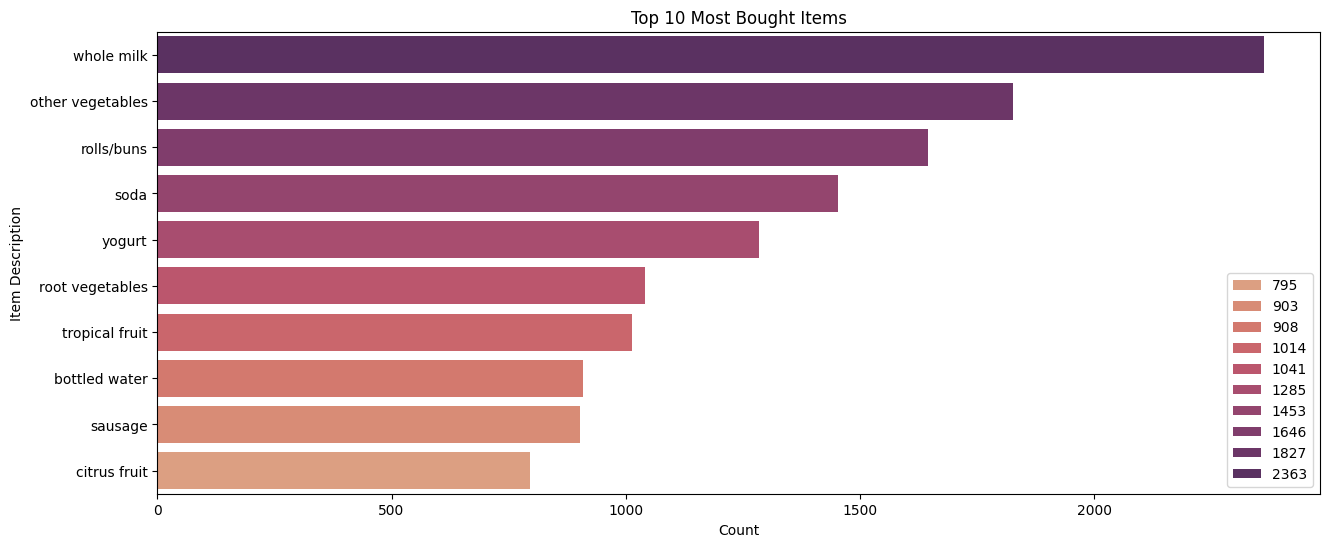

In [24]:
#Top 10 Most bought items
bought_items = groceries_df['itemDescription'].value_counts().head(10)
#set the palette color
palette = sns.color_palette("flare", 10)
plt.figure(figsize=(15, 6))
sns.barplot(y=bought_items.index, x=bought_items.values, hue=bought_items.values, palette=palette)
plt.title('Top 10 Most Bought Items')
plt.xlabel('Count')
plt.ylabel('Item Description')
plt.show()


### 10 Least bought items 

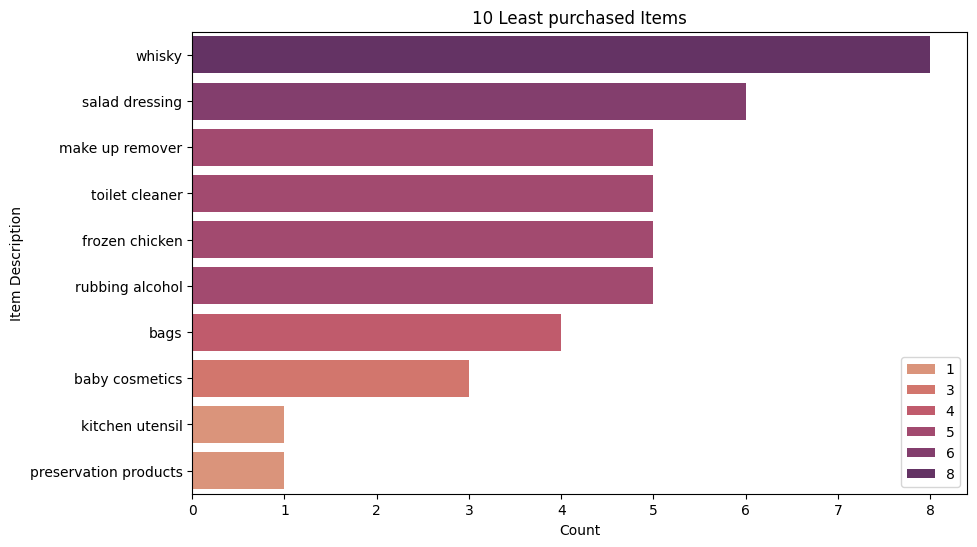

In [25]:
# 10 least bought items
bought_items = groceries_df['itemDescription'].value_counts().tail(10)
#set the palette color
palette = sns.color_palette("flare", 6)
plt.figure(figsize=(10, 6))
sns.barplot(y=bought_items.index, x=bought_items.values, hue=bought_items.values, palette=palette)
plt.title('10 Least purchased Items')
plt.xlabel('Count')
plt.ylabel('Item Description')
plt.show()

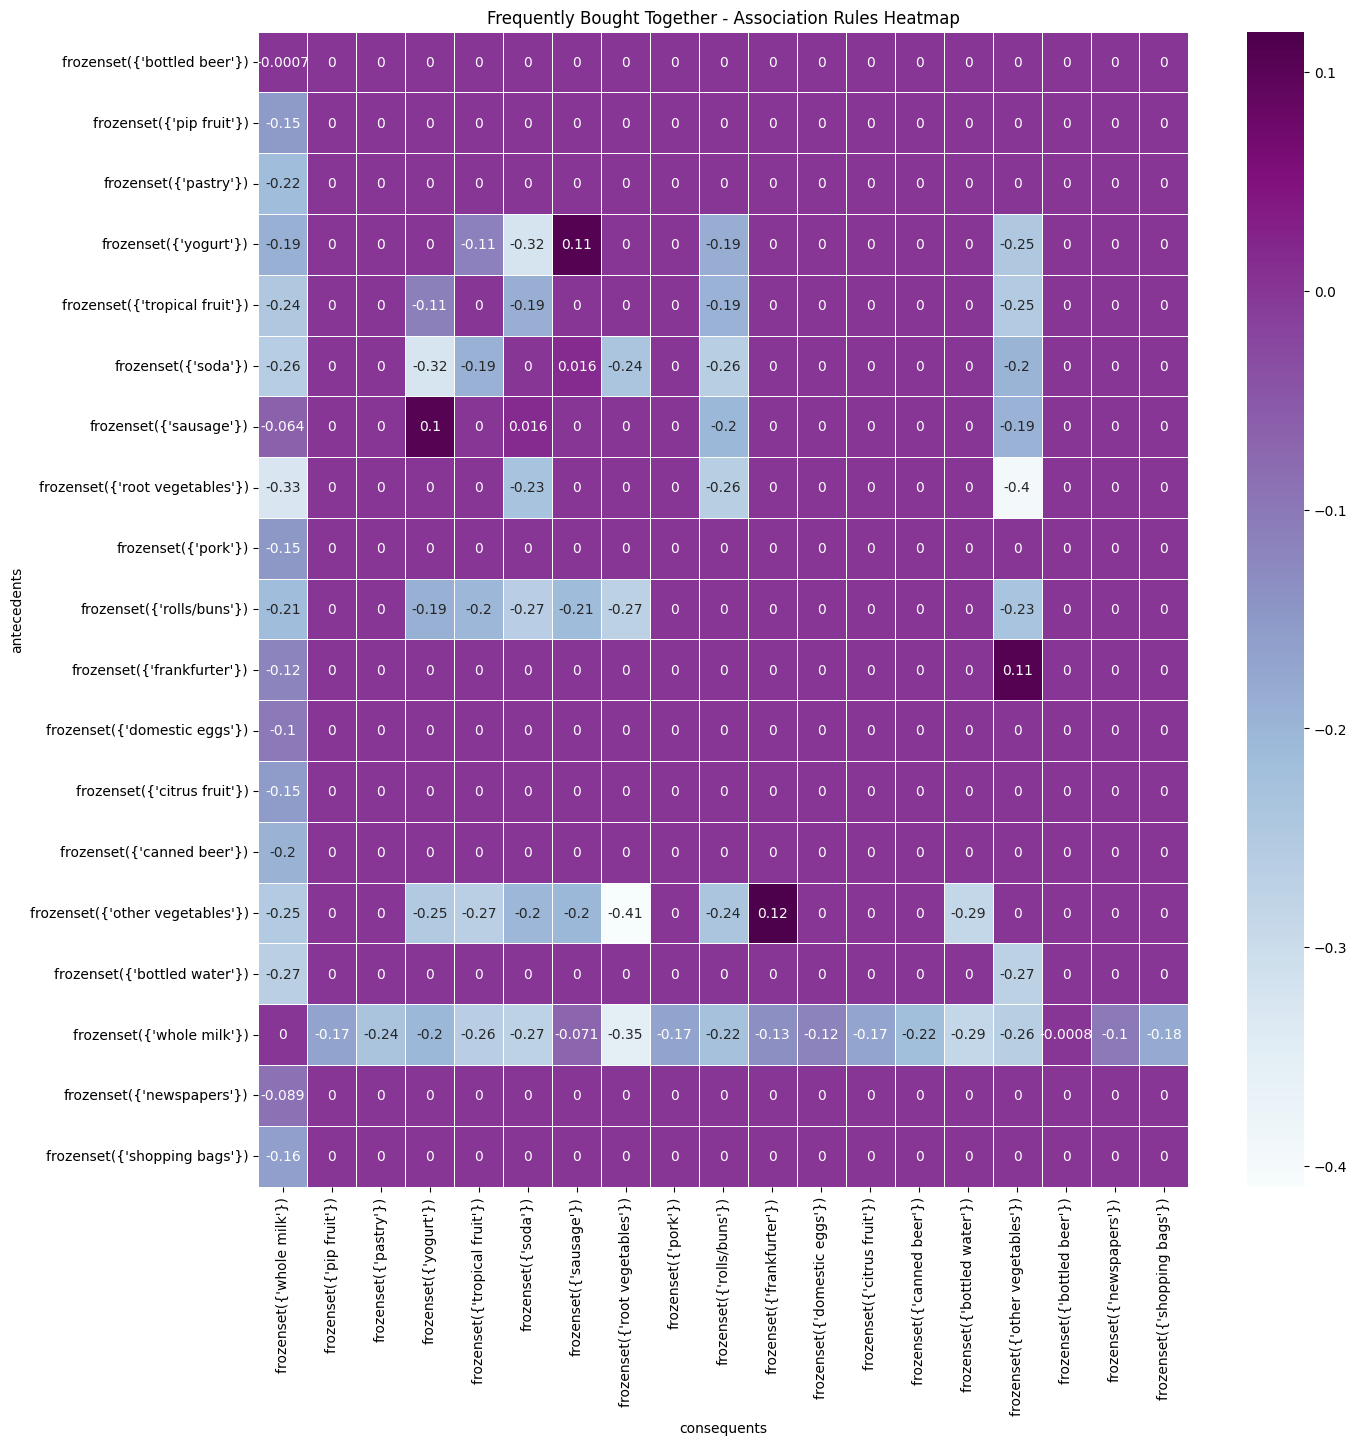

In [26]:
# Create a matrix of product associations
product_associations = rules.pivot(index='antecedents', columns='consequents', values='zhangs_metric').fillna(0)

# Create a heatmap of all associations
plt.figure(figsize=(15, 15))
sns.heatmap(product_associations, annot=True, cmap="BuPu", fmt=".2g", linewidths=.5)
plt.title("Frequently Bought Together - Association Rules Heatmap")
plt.show()



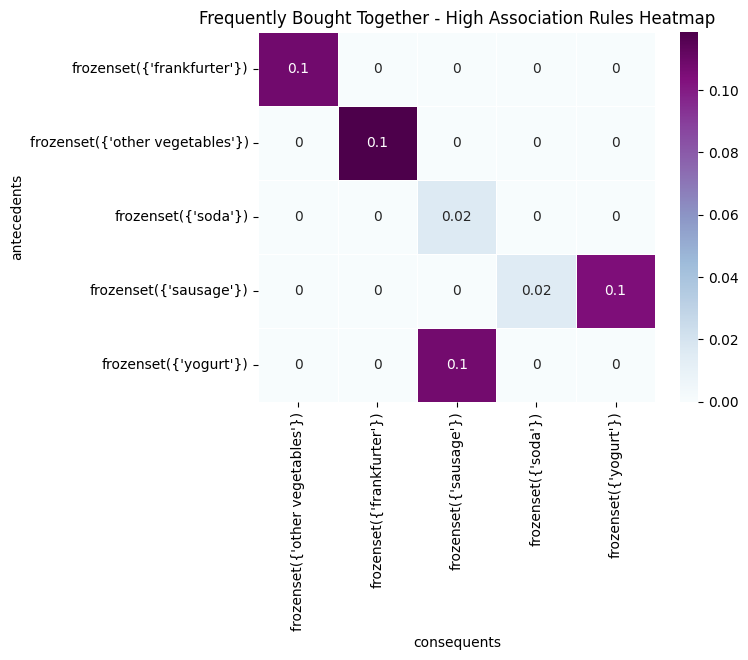

In [27]:
# heatmap for products with high association
nr = rules[rules['zhangs_metric'] > 0]
strong_association = nr.pivot(index='antecedents', columns='consequents', values='zhangs_metric').fillna(0)
sns.heatmap(strong_association, annot=True, cmap="BuPu", fmt=".1g", linewidths=.5)
plt.title("Frequently Bought Together - High Association Rules Heatmap")
plt.show()

# Step 5: Interpretation and insights

### Exploratory analysis 
+ The total number of unique customers is: `3898`
+ The number of unique items purchased is: `167`
+ The average number of visits per customer is: `4`
+ `1849` customers have visited the store less than 4 times, that is `47.43 %` of the total customers
+ `52.57 %` percent of the total customers have visited the store more than 4 times.
+ The average number items bought per customer is `10`  with over 500 customers falling into this category.
+ `2061` customers have bought less than 10 items, that is `52.87 %` of the total customers 
+ As the number of items bought increases, the number of customers who bought that many items generally decreases. This suggests that most customers tend to buy a smaller number of items.
+ The number of items purchased have increased from the year 2014 to 2015 by `10.85 %`
+ The month with the highest cumulative items purchased is August
+ December has the least cumulative number of items purchased
+ There are significant rise and drops in the number of items sold through the months
### Market Basket Analysis
+ whole milk, other vegetables, rolls/buns, soda, yogurt are the most frequently boughts items
+ Frankfurters and other vegetables are frequently bought together. This has a lift of `0.1`, which means that customers who buy frankfurters are 10% more likely to also buy other vegetables than customers who do not buy frankfurters.
+ Sausages are frequently bought together with yogurt. This suggests that people who buy other sausages are likely to also buy yogurt
+ Soda and sausages are slightly likely to be bought together

# Step 6: Recommendations

<font size=3>
    <ul>
<li> Most customers tend to buy goods in small quantities while a few buy in bulk, the store could offer bulk discounts to attract more of the customers who tend to buy a large number of items. </li>
<li> The percentage of customers who have shopped less than 4 times is a bit high, or they could be one time buyers. Investigations should be done to check whether it is due to customer churn or they are just infrequent customers who purchase in bulk.</li>
<li> Segment customers based on their purchase frequency and average number of items per basket. You could target infrequent shoppers with promotional offers to encourage them to shop more often, and you could target frequent shoppers with loyalty programs and exclusive discounts </li>
<li> Utilize seasonal trends to inform your promotional campaigns. For example, you could create marketing campaigns during months that show low sales </li>
<li> Place frequently bought items together (sausages and soda; other vegetables and frankfurters, sausages and yoghurt) </li>
<li> Highlight complementary products through cross-selling promotions. This could involve offering discounts on complementary items when a customer purchases a particular product, or it could involve sending targeted emails or notifications to customers about products that they may be interested in based on their past purchases.</li>
    </ul>
 </font>